In [1]:
### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

In [2]:
yf.pdr_override()
df = pdr.get_data_yahoo("NKD=F", start="2015-01-01", end="2023-04-06")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,17415.0,17675.0,17395.0,17470.0,17470.0,9904
2015-01-05,17470.0,17635.0,17105.0,17160.0,17160.0,22614
2015-01-06,17155.0,17175.0,16605.0,16790.0,16790.0,31334
2015-01-07,16790.0,17225.0,16755.0,17070.0,17070.0,19357
2015-01-08,17065.0,17490.0,17060.0,17420.0,17420.0,15643


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-30,27885.0,28040.0,27690.0,28000.0,28000.0,3008
2023-03-31,28010.0,28305.0,27995.0,28270.0,28270.0,3210
2023-04-03,28240.0,28340.0,28110.0,28270.0,28270.0,2273
2023-04-04,28255.0,28390.0,28075.0,28155.0,28155.0,2592
2023-04-05,28170.0,28210.0,27635.0,27760.0,27760.0,2967


In [5]:
df1=df.reset_index()['High']

In [6]:
df1

0       17675.0
1       17635.0
2       17175.0
3       17225.0
4       17490.0
         ...   
2073    28040.0
2074    28305.0
2075    28340.0
2076    28390.0
2077    28210.0
Name: High, Length: 2078, dtype: float64

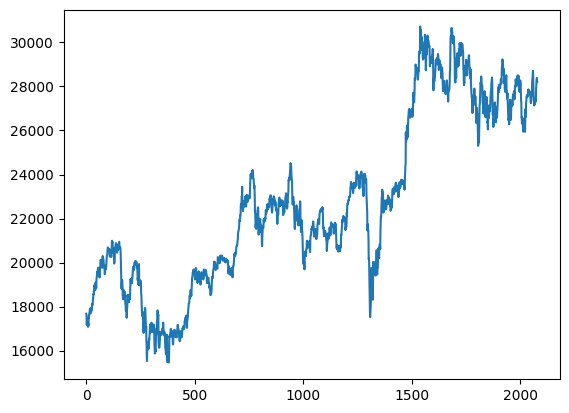

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [9]:
import numpy as np

In [10]:
df1

0       17675.0
1       17635.0
2       17175.0
3       17225.0
4       17490.0
         ...   
2073    28040.0
2074    28305.0
2075    28340.0
2076    28390.0
2077    28210.0
Name: High, Length: 2078, dtype: float64

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
df1

array([[0.14510318],
       [0.1424828 ],
       [0.11234851],
       ...,
       [0.84376024],
       [0.8470357 ],
       [0.83524402]])

In [13]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [14]:
training_size,test_size

(1350, 728)

In [15]:
train_data

array([[0.14510318],
       [0.1424828 ],
       [0.11234851],
       ...,
       [0.32590894],
       [0.31411726],
       [0.31084179]])

In [16]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(1249, 100)
(1249,)


(None, None)

In [19]:
print(X_test.shape), print(ytest.shape)

(627, 100)
(627,)


(None, None)

In [20]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 12s 295ms/step - loss: 0.0242 - val_loss: 0.0522
Epoch 2/100
20/20 [==============================] - 4s 193ms/step - loss: 0.0048 - val_loss: 0.0193
Epoch 3/100
20/20 [==============================] - 4s 184ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 4/100
20/20 [==============================] - 4s 184ms/step - loss: 0.0022 - val_loss: 0.0069
Epoch 5/100
20/20 [==============================] - 4s 211ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 6/100
20/20 [==============================] - 4s 207ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 7/100
20/20 [==============================] - 4s 188ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 8/100
20/20 [==============================] - 4s 200ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/100
20/20 [==============================] - 4s 218ms/step - loss: 0.0014 - val_loss: 0.0081
Epoch 10/100
20/20 [==============================] - 5s 243ms/step - loss: 0.0013 - val_l

20/20 [==============================] - 5s 247ms/step - loss: 3.7934e-04 - val_loss: 4.5350e-04
Epoch 79/100
20/20 [==============================] - 4s 180ms/step - loss: 3.5519e-04 - val_loss: 0.0033
Epoch 80/100
20/20 [==============================] - 5s 230ms/step - loss: 3.4722e-04 - val_loss: 0.0034
Epoch 81/100
20/20 [==============================] - 5s 229ms/step - loss: 2.8315e-04 - val_loss: 5.6607e-04
Epoch 82/100
20/20 [==============================] - 4s 223ms/step - loss: 2.9615e-04 - val_loss: 0.0016
Epoch 83/100
20/20 [==============================] - 4s 201ms/step - loss: 2.7251e-04 - val_loss: 3.9318e-04
Epoch 84/100
20/20 [==============================] - 4s 210ms/step - loss: 3.3677e-04 - val_loss: 6.2703e-04
Epoch 85/100
20/20 [==============================] - 5s 241ms/step - loss: 2.7845e-04 - val_loss: 5.0456e-04
Epoch 86/100
20/20 [==============================] - 4s 221ms/step - loss: 2.8050e-04 - val_loss: 0.0017
Epoch 87/100
20/20 [===================

In [26]:
import tensorflow as tf

In [27]:
tf.__version__

'2.10.0'

In [28]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

20/20 [==============================] - 1s 42ms/step


In [29]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [30]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20445.851388322983

In [31]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

27587.603940868707

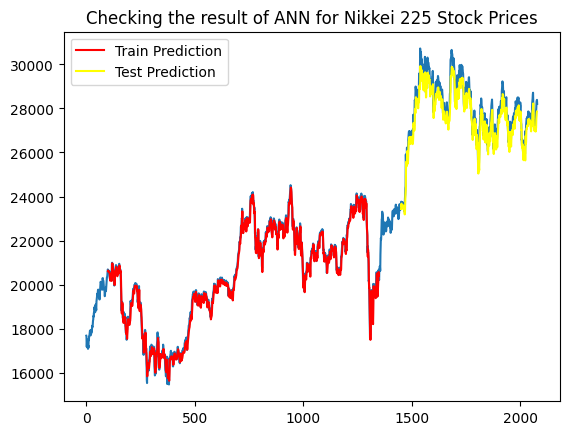

In [32]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot, color = "red", label = "Train Prediction")
plt.plot(testPredictPlot, color = "yellow", label = "Test Prediction")
plt.legend()
plt.title("Checking the result of ANN for Nikkei 225 Stock Prices")
plt.show()

In [33]:
len(test_data)

728

In [34]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 387)

In [35]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [36]:
temp_input

[0.9669177857844742,
 0.9708483458892891,
 0.9600393056010481,
 0.9452997052079921,
 0.9416966917785785,
 0.9168031444480838,
 0.9030461840812316,
 0.8424500491320013,
 0.8395021290533902,
 0.8332787422207664,
 0.8447428758598099,
 0.8745496233213232,
 0.8555519161480512,
 0.8476907959384212,
 0.8765149033737307,
 0.9053390108090402,
 0.9073042908614477,
 0.9151654110710776,
 0.9204061578774976,
 0.9095971175892565,
 0.8876514903373731,
 0.8807730101539468,
 0.9046839174582377,
 0.8971503439240092,
 0.8830658368817557,
 0.8919095971175892,
 0.9315427448411397,
 0.9269570913855225,
 0.9390763183753685,
 0.9505404520144121,
 0.9426793318047821,
 0.9426793318047821,
 0.9407140517523747,
 0.9125450376678677,
 0.9190959711758926,
 0.9374385849983622,
 0.9439895185063871,
 0.9511955453652146,
 0.9482476252866032,
 0.9348182115951522,
 0.9390763183753685,
 0.9472649852603996,
 0.9387487716999672,
 0.9364559449721586,
 0.9253193580085162,
 0.9253193580085162,
 0.8732394366197183,
 0.8686537831

In [38]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=386
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.97084835 0.96003931 0.94529971 0.94169669 0.91680314 0.90304618
 0.84245005 0.83950213 0.83327874 0.84474288 0.87454962 0.85555192
 0.8476908  0.8765149  0.90533901 0.90730429 0.91516541 0.92040616
 0.90959712 0.88765149 0.88077301 0.90468392 0.89715034 0.88306584
 0.8919096  0.93154274 0.92695709 0.93907632 0.95054045 0.94267933
 0.94267933 0.94071405 0.91254504 0.91909597 0.93743858 0.94398952
 0.95119555 0.94824763 0.93481821 0.93907632 0.94726499 0.93874877
 0.93645594 0.92531936 0.92531936 0.87323944 0.86865378 0.8372093
 0.82509008 0.83327874 0.83196856 0.87848018 0.88306584 0.88306584
 0.86963642 0.87585981 0.8673436  0.88339338 0.90075336 0.88175565
 0.85391418 0.86865378 0.86996397 0.88273829 0.88994432 0.89485752
 0.89584016 0.88666885 0.88961677 0.89977072 0.91352768 0.91451032
 0.8968228  0.87618736 0.86079266 0.85424173 0.87585981 0.8673436
 0.84474288 0.87094661 0.82541762 0.81919424 0.80248935 0.79692106
 0.78742221 0.78381919 0.76907959 0.74254831 0.77890

1 day output [[0.7819259]]
2 day input [0.94529971 0.94169669 0.91680314 0.90304618 0.84245005 0.83950213
 0.83327874 0.84474288 0.87454962 0.85555192 0.8476908  0.8765149
 0.90533901 0.90730429 0.91516541 0.92040616 0.90959712 0.88765149
 0.88077301 0.90468392 0.89715034 0.88306584 0.8919096  0.93154274
 0.92695709 0.93907632 0.95054045 0.94267933 0.94267933 0.94071405
 0.91254504 0.91909597 0.93743858 0.94398952 0.95119555 0.94824763
 0.93481821 0.93907632 0.94726499 0.93874877 0.93645594 0.92531936
 0.92531936 0.87323944 0.86865378 0.8372093  0.82509008 0.83327874
 0.83196856 0.87848018 0.88306584 0.88306584 0.86963642 0.87585981
 0.8673436  0.88339338 0.90075336 0.88175565 0.85391418 0.86865378
 0.86996397 0.88273829 0.88994432 0.89485752 0.89584016 0.88666885
 0.88961677 0.89977072 0.91352768 0.91451032 0.8968228  0.87618736
 0.86079266 0.85424173 0.87585981 0.8673436  0.84474288 0.87094661
 0.82541762 0.81919424 0.80248935 0.79692106 0.78742221 0.78381919
 0.76907959 0.74254831 0

4 day output [[0.73569745]]
5 day input [0.90304618 0.84245005 0.83950213 0.83327874 0.84474288 0.87454962
 0.85555192 0.8476908  0.8765149  0.90533901 0.90730429 0.91516541
 0.92040616 0.90959712 0.88765149 0.88077301 0.90468392 0.89715034
 0.88306584 0.8919096  0.93154274 0.92695709 0.93907632 0.95054045
 0.94267933 0.94267933 0.94071405 0.91254504 0.91909597 0.93743858
 0.94398952 0.95119555 0.94824763 0.93481821 0.93907632 0.94726499
 0.93874877 0.93645594 0.92531936 0.92531936 0.87323944 0.86865378
 0.8372093  0.82509008 0.83327874 0.83196856 0.87848018 0.88306584
 0.88306584 0.86963642 0.87585981 0.8673436  0.88339338 0.90075336
 0.88175565 0.85391418 0.86865378 0.86996397 0.88273829 0.88994432
 0.89485752 0.89584016 0.88666885 0.88961677 0.89977072 0.91352768
 0.91451032 0.8968228  0.87618736 0.86079266 0.85424173 0.87585981
 0.8673436  0.84474288 0.87094661 0.82541762 0.81919424 0.80248935
 0.79692106 0.78742221 0.78381919 0.76907959 0.74254831 0.77890599
 0.78349165 0.79430069

7 day output [[0.7037119]]
8 day input [0.83327874 0.84474288 0.87454962 0.85555192 0.8476908  0.8765149
 0.90533901 0.90730429 0.91516541 0.92040616 0.90959712 0.88765149
 0.88077301 0.90468392 0.89715034 0.88306584 0.8919096  0.93154274
 0.92695709 0.93907632 0.95054045 0.94267933 0.94267933 0.94071405
 0.91254504 0.91909597 0.93743858 0.94398952 0.95119555 0.94824763
 0.93481821 0.93907632 0.94726499 0.93874877 0.93645594 0.92531936
 0.92531936 0.87323944 0.86865378 0.8372093  0.82509008 0.83327874
 0.83196856 0.87848018 0.88306584 0.88306584 0.86963642 0.87585981
 0.8673436  0.88339338 0.90075336 0.88175565 0.85391418 0.86865378
 0.86996397 0.88273829 0.88994432 0.89485752 0.89584016 0.88666885
 0.88961677 0.89977072 0.91352768 0.91451032 0.8968228  0.87618736
 0.86079266 0.85424173 0.87585981 0.8673436  0.84474288 0.87094661
 0.82541762 0.81919424 0.80248935 0.79692106 0.78742221 0.78381919
 0.76907959 0.74254831 0.77890599 0.78349165 0.79430069 0.78218146
 0.78611202 0.78119882 0

10 day output [[0.66724]]
11 day input [0.85555192 0.8476908  0.8765149  0.90533901 0.90730429 0.91516541
 0.92040616 0.90959712 0.88765149 0.88077301 0.90468392 0.89715034
 0.88306584 0.8919096  0.93154274 0.92695709 0.93907632 0.95054045
 0.94267933 0.94267933 0.94071405 0.91254504 0.91909597 0.93743858
 0.94398952 0.95119555 0.94824763 0.93481821 0.93907632 0.94726499
 0.93874877 0.93645594 0.92531936 0.92531936 0.87323944 0.86865378
 0.8372093  0.82509008 0.83327874 0.83196856 0.87848018 0.88306584
 0.88306584 0.86963642 0.87585981 0.8673436  0.88339338 0.90075336
 0.88175565 0.85391418 0.86865378 0.86996397 0.88273829 0.88994432
 0.89485752 0.89584016 0.88666885 0.88961677 0.89977072 0.91352768
 0.91451032 0.8968228  0.87618736 0.86079266 0.85424173 0.87585981
 0.8673436  0.84474288 0.87094661 0.82541762 0.81919424 0.80248935
 0.79692106 0.78742221 0.78381919 0.76907959 0.74254831 0.77890599
 0.78349165 0.79430069 0.78218146 0.78611202 0.78119882 0.78643957
 0.8132984  0.81526368 

13 day output [[0.6263904]]
14 day input [0.90533901 0.90730429 0.91516541 0.92040616 0.90959712 0.88765149
 0.88077301 0.90468392 0.89715034 0.88306584 0.8919096  0.93154274
 0.92695709 0.93907632 0.95054045 0.94267933 0.94267933 0.94071405
 0.91254504 0.91909597 0.93743858 0.94398952 0.95119555 0.94824763
 0.93481821 0.93907632 0.94726499 0.93874877 0.93645594 0.92531936
 0.92531936 0.87323944 0.86865378 0.8372093  0.82509008 0.83327874
 0.83196856 0.87848018 0.88306584 0.88306584 0.86963642 0.87585981
 0.8673436  0.88339338 0.90075336 0.88175565 0.85391418 0.86865378
 0.86996397 0.88273829 0.88994432 0.89485752 0.89584016 0.88666885
 0.88961677 0.89977072 0.91352768 0.91451032 0.8968228  0.87618736
 0.86079266 0.85424173 0.87585981 0.8673436  0.84474288 0.87094661
 0.82541762 0.81919424 0.80248935 0.79692106 0.78742221 0.78381919
 0.76907959 0.74254831 0.77890599 0.78349165 0.79430069 0.78218146
 0.78611202 0.78119882 0.78643957 0.8132984  0.81526368 0.78578447
 0.76776941 0.7867671

16 day output [[0.58255994]]
17 day input [0.92040616 0.90959712 0.88765149 0.88077301 0.90468392 0.89715034
 0.88306584 0.8919096  0.93154274 0.92695709 0.93907632 0.95054045
 0.94267933 0.94267933 0.94071405 0.91254504 0.91909597 0.93743858
 0.94398952 0.95119555 0.94824763 0.93481821 0.93907632 0.94726499
 0.93874877 0.93645594 0.92531936 0.92531936 0.87323944 0.86865378
 0.8372093  0.82509008 0.83327874 0.83196856 0.87848018 0.88306584
 0.88306584 0.86963642 0.87585981 0.8673436  0.88339338 0.90075336
 0.88175565 0.85391418 0.86865378 0.86996397 0.88273829 0.88994432
 0.89485752 0.89584016 0.88666885 0.88961677 0.89977072 0.91352768
 0.91451032 0.8968228  0.87618736 0.86079266 0.85424173 0.87585981
 0.8673436  0.84474288 0.87094661 0.82541762 0.81919424 0.80248935
 0.79692106 0.78742221 0.78381919 0.76907959 0.74254831 0.77890599
 0.78349165 0.79430069 0.78218146 0.78611202 0.78119882 0.78643957
 0.8132984  0.81526368 0.78578447 0.76776941 0.78676711 0.79233541
 0.79037013 0.770389

19 day output [[0.5362221]]
20 day input [0.88077301 0.90468392 0.89715034 0.88306584 0.8919096  0.93154274
 0.92695709 0.93907632 0.95054045 0.94267933 0.94267933 0.94071405
 0.91254504 0.91909597 0.93743858 0.94398952 0.95119555 0.94824763
 0.93481821 0.93907632 0.94726499 0.93874877 0.93645594 0.92531936
 0.92531936 0.87323944 0.86865378 0.8372093  0.82509008 0.83327874
 0.83196856 0.87848018 0.88306584 0.88306584 0.86963642 0.87585981
 0.8673436  0.88339338 0.90075336 0.88175565 0.85391418 0.86865378
 0.86996397 0.88273829 0.88994432 0.89485752 0.89584016 0.88666885
 0.88961677 0.89977072 0.91352768 0.91451032 0.8968228  0.87618736
 0.86079266 0.85424173 0.87585981 0.8673436  0.84474288 0.87094661
 0.82541762 0.81919424 0.80248935 0.79692106 0.78742221 0.78381919
 0.76907959 0.74254831 0.77890599 0.78349165 0.79430069 0.78218146
 0.78611202 0.78119882 0.78643957 0.8132984  0.81526368 0.78578447
 0.76776941 0.78676711 0.79233541 0.79037013 0.77038978 0.75761546
 0.74909925 0.7124140

22 day output [[0.4879975]]
23 day input [0.88306584 0.8919096  0.93154274 0.92695709 0.93907632 0.95054045
 0.94267933 0.94267933 0.94071405 0.91254504 0.91909597 0.93743858
 0.94398952 0.95119555 0.94824763 0.93481821 0.93907632 0.94726499
 0.93874877 0.93645594 0.92531936 0.92531936 0.87323944 0.86865378
 0.8372093  0.82509008 0.83327874 0.83196856 0.87848018 0.88306584
 0.88306584 0.86963642 0.87585981 0.8673436  0.88339338 0.90075336
 0.88175565 0.85391418 0.86865378 0.86996397 0.88273829 0.88994432
 0.89485752 0.89584016 0.88666885 0.88961677 0.89977072 0.91352768
 0.91451032 0.8968228  0.87618736 0.86079266 0.85424173 0.87585981
 0.8673436  0.84474288 0.87094661 0.82541762 0.81919424 0.80248935
 0.79692106 0.78742221 0.78381919 0.76907959 0.74254831 0.77890599
 0.78349165 0.79430069 0.78218146 0.78611202 0.78119882 0.78643957
 0.8132984  0.81526368 0.78578447 0.76776941 0.78676711 0.79233541
 0.79037013 0.77038978 0.75761546 0.74909925 0.71241402 0.75565018
 0.75040943 0.7572879

25 day output [[0.43942204]]
26 day input [0.92695709 0.93907632 0.95054045 0.94267933 0.94267933 0.94071405
 0.91254504 0.91909597 0.93743858 0.94398952 0.95119555 0.94824763
 0.93481821 0.93907632 0.94726499 0.93874877 0.93645594 0.92531936
 0.92531936 0.87323944 0.86865378 0.8372093  0.82509008 0.83327874
 0.83196856 0.87848018 0.88306584 0.88306584 0.86963642 0.87585981
 0.8673436  0.88339338 0.90075336 0.88175565 0.85391418 0.86865378
 0.86996397 0.88273829 0.88994432 0.89485752 0.89584016 0.88666885
 0.88961677 0.89977072 0.91352768 0.91451032 0.8968228  0.87618736
 0.86079266 0.85424173 0.87585981 0.8673436  0.84474288 0.87094661
 0.82541762 0.81919424 0.80248935 0.79692106 0.78742221 0.78381919
 0.76907959 0.74254831 0.77890599 0.78349165 0.79430069 0.78218146
 0.78611202 0.78119882 0.78643957 0.8132984  0.81526368 0.78578447
 0.76776941 0.78676711 0.79233541 0.79037013 0.77038978 0.75761546
 0.74909925 0.71241402 0.75565018 0.75040943 0.75728791 0.73665247
 0.73861775 0.719292

28 day output [[0.393138]]
29 day input [0.94267933 0.94267933 0.94071405 0.91254504 0.91909597 0.93743858
 0.94398952 0.95119555 0.94824763 0.93481821 0.93907632 0.94726499
 0.93874877 0.93645594 0.92531936 0.92531936 0.87323944 0.86865378
 0.8372093  0.82509008 0.83327874 0.83196856 0.87848018 0.88306584
 0.88306584 0.86963642 0.87585981 0.8673436  0.88339338 0.90075336
 0.88175565 0.85391418 0.86865378 0.86996397 0.88273829 0.88994432
 0.89485752 0.89584016 0.88666885 0.88961677 0.89977072 0.91352768
 0.91451032 0.8968228  0.87618736 0.86079266 0.85424173 0.87585981
 0.8673436  0.84474288 0.87094661 0.82541762 0.81919424 0.80248935
 0.79692106 0.78742221 0.78381919 0.76907959 0.74254831 0.77890599
 0.78349165 0.79430069 0.78218146 0.78611202 0.78119882 0.78643957
 0.8132984  0.81526368 0.78578447 0.76776941 0.78676711 0.79233541
 0.79037013 0.77038978 0.75761546 0.74909925 0.71241402 0.75565018
 0.75040943 0.75728791 0.73665247 0.73861775 0.7192925  0.67474615
 0.64461186 0.65443826

In [39]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [40]:
import matplotlib.pyplot as plt

In [41]:
len(df1)

2078

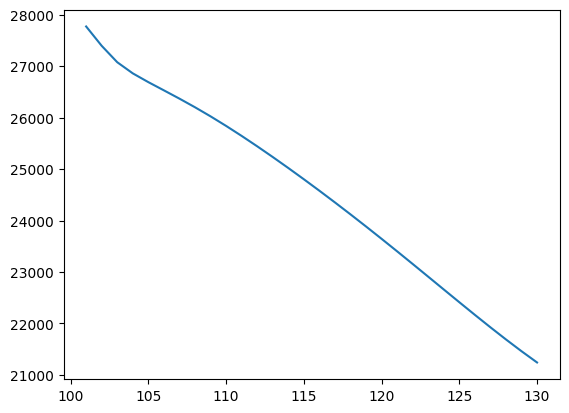

In [42]:
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [43]:
df1

array([[0.14510318],
       [0.1424828 ],
       [0.11234851],
       ...,
       [0.84376024],
       [0.8470357 ],
       [0.83524402]])

In [44]:
df1 = scaler.inverse_transform(df1[1158:])
lst_output = scaler.inverse_transform(lst_output)

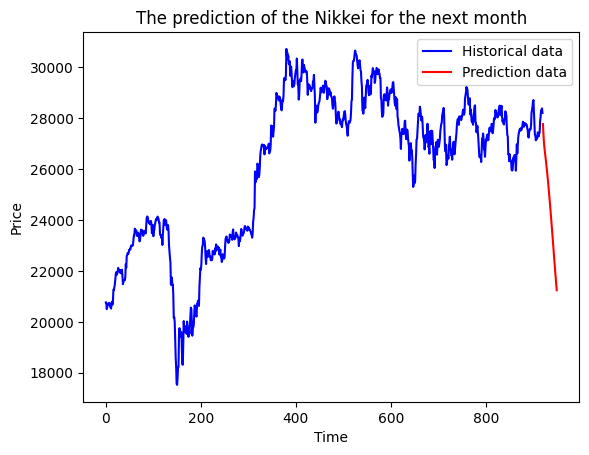

In [45]:
# plot df1
plt.plot(df1, color='blue', label='Historical data')

# plot lst_output starting at the end of df1
plt.plot(range(len(df1), len(df1) + len(lst_output)), lst_output, color='red', label='Prediction data')

# add legend and labels
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title("The prediction of the Nikkei for the next month")

# show the plot
plt.show()